In [52]:
import numpy as np
from utility import *

In [53]:
weights = np.array([[14,0,0,0,0],
[88,1,0,0,0],
[39,61,0,0,0],
[0,75,25,0,0],
[0,4,91,4,0],
[0,0,25,75,0],
[0,0,0,61,39],
[0,0,0,1,88],
[0,0,0,0,14]])/100

In [54]:
source = np.array([
[0,0,0,0,2],
[0,9,0,0,0],
[0,0,0,0,0],
[0,7,0,8,0],
[0,0,0,0,0]])

source \begin{pmatrix}
  0 & 0 & 0 & 0 & 2\\
  0 & 9 & 0 & 0 & 0\\
  0 & 0 & 0 & 0 & 0\\
  0 & 7 & 0 & 8 & 0\\
  0 & 0 & 0 & 0 & 0\\
\end{pmatrix}


(<Figure size 144x144 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5281147fa0>)

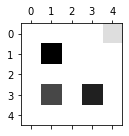

In [55]:
create_matrix_image(source, save=('source', 'theory'))

In [56]:
proj = calc_projection_matrix(source, weights)

projection \begin{pmatrix}
  0. & 16. & 0. & 8. & 2.\\
  2.73 & 4.95 & 15.47 & 0.68 & 0.28\\
  0. & 15. & 0. & 9. & 2.\\
  3.12 & 5.24 & 8.19 & 5.85 & 3.51\\
\end{pmatrix}


(<Figure size 144x144 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f528112f910>)

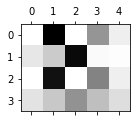

In [57]:
create_matrix_image(proj, save=('projection', 'theory'))

In [58]:
conv = convolute_projection(proj)

convoluted \begin{pmatrix}
  -1.6 & 4. & -2.4 & 1.8 & -0.3\\
  0.188 & -0.583 & 3.304 & -1.405 & 0.002\\
  -1.5 & 3.75 & -2.4 & 2.05 & -0.4\\
  0.256 & 0.179 & 0.938 & 0.293 & 0.292\\
\end{pmatrix}


(<Figure size 144x144 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5281079550>)

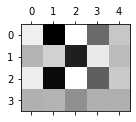

In [59]:
create_matrix_image(conv, save=('convoluted', 'theory'))

In [60]:
backweights = np.array([
    [27, 100, 72, 0, 0, 0, 0, 0, 0],
    [0, 1, 93, 99, 7, 0, 0, 0, 0],
    [0, 0, 0, 50, 100, 50, 0, 0, 0],
    [0, 0, 0, 0, 7, 99, 93, 1, 0],
    [0, 0, 0, 0, 0, 0, 73, 100, 27]])/100

Reconstructed Diagonals
45 \begin{pmatrix}
  0.737 & 2.78 & 6.569 & 12.636 & 15.864 & 8.408 & 0.837 & 0.287 & 0.076\\
\end{pmatrix}
135 \begin{pmatrix}
  0.842 & 3.172 & 7.12 & 9.283 & 8.966 & 9.886 & 8.003 & 3.569 & 0.948\\
\end{pmatrix}
0 \begin{pmatrix}
  0. & 16. & 0. & 8. & 2.\\
  0. & 16. & 0. & 8. & 2.\\
  0. & 16. & 0. & 8. & 2.\\
  0. & 16. & 0. & 8. & 2.\\
  0. & 16. & 0. & 8. & 2.\\
\end{pmatrix}
45 \begin{pmatrix}
  15.864 & 8.408 & 0.837 & 0.287 & 0.076\\
  12.636 & 15.864 & 8.408 & 0.837 & 0.287\\
  6.569 & 12.636 & 15.864 & 8.408 & 0.837\\
  2.78 & 6.569 & 12.636 & 15.864 & 8.408\\
  0.737 & 2.78 & 6.569 & 12.636 & 15.864\\
\end{pmatrix}
90 \begin{pmatrix}
  2. & 2. & 2. & 2. & 2.\\
  9. & 9. & 9. & 9. & 9.\\
  0. & 0. & 0. & 0. & 0.\\
  15. & 15. & 15. & 15. & 15.\\
  0. & 0. & 0. & 0. & 0.\\
\end{pmatrix}
135 \begin{pmatrix}
  0.842 & 3.172 & 7.12 & 9.283 & 8.966\\
  3.172 & 7.12 & 9.283 & 8.966 & 9.886\\
  7.12 & 9.283 & 8.966 & 9.886 & 8.003\\
  9.283 & 8.966 & 9.886

rec_simple \begin{pmatrix}
  10.353 & 23.79 & 5.978 & 14.785 & 8.521\\
  16.904 & 36.492 & 17.845 & 21.902 & 16.087\\
  6.844 & 26.959 & 12.415 & 17.147 & 6.42\\
  21.031 & 38.768 & 26.261 & 34.933 & 22.988\\
  4.852 & 22.333 & 7.286 & 16.102 & 10.406\\
\end{pmatrix}


(<Figure size 144x144 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f528104aac0>)

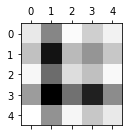

In [61]:
create_matrix_image(reconstruct(proj, backweights), save=('rec_simple', 'theory'))cc

Reconstructed Diagonals
45 \begin{pmatrix}
  0.051 & 0.182 & -0.407 & 1.076 & 3.165 & 0.261 & -1.305 & -0.012 & 0.001\\
\end{pmatrix}
135 \begin{pmatrix}
  0.069 & 0.258 & 0.351 & 0.646 & 0.972 & 0.759 & 0.486 & 0.295 & 0.079\\
\end{pmatrix}
0 \begin{pmatrix}
  -1.6 & 4. & -2.4 & 1.8 & -0.3\\
  -1.6 & 4. & -2.4 & 1.8 & -0.3\\
  -1.6 & 4. & -2.4 & 1.8 & -0.3\\
  -1.6 & 4. & -2.4 & 1.8 & -0.3\\
  -1.6 & 4. & -2.4 & 1.8 & -0.3\\
\end{pmatrix}
45 \begin{pmatrix}
  3.165 & 0.261 & -1.305 & -0.012 & 0.001\\
  1.076 & 3.165 & 0.261 & -1.305 & -0.012\\
  -0.407 & 1.076 & 3.165 & 0.261 & -1.305\\
  0.182 & -0.407 & 1.076 & 3.165 & 0.261\\
  0.051 & 0.182 & -0.407 & 1.076 & 3.165\\
\end{pmatrix}
90 \begin{pmatrix}
  -0.4 & -0.4 & -0.4 & -0.4 & -0.4\\
  2.05 & 2.05 & 2.05 & 2.05 & 2.05\\
  -2.4 & -2.4 & -2.4 & -2.4 & -2.4\\
  3.75 & 3.75 & 3.75 & 3.75 & 3.75\\
  -1.5 & -1.5 & -1.5 & -1.5 & -1.5\\
\end{pmatrix}
135 \begin{pmatrix}
  0.069 & 0.258 & 0.351 & 0.646 & 0.972\\
  0.258 & 0.351 & 0.646 &

(<Figure size 144x144 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f528100dd30>)

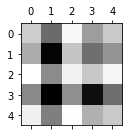

In [63]:
create_matrix_image(reconstruct(conv, backweights), save=('rec_filtered', 'theory'))